# Playing with the ACTS dataset

In this notebook I demonstrate some usage of the ACTS files from Paolo which live here:

https://drive.google.com/open?id=0BwwNm5ARrRgQQ2pRX2NmUmhZLUE

I make some raw plots, demonstrate a few quirks with the data, and develop some preliminary fixes.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib notebook

## Utilities

In [2]:
def calc_eta(theta):
    """Calculates eta from a theta value or flat array"""
    return -1. * np.log(np.tan(theta / 2.))

def calc_phi(rphi, r):
    """Calculates phi from rphi"""
    return rphi / r
# I vectorize it to work on an array of arrays
calc_phi = np.vectorize(calc_phi, otypes='O')

def filter_samples(idx, *arrays):
    """Apply a filter index to a list of arrays"""
    return map(lambda x: x[idx], arrays)

## Load the data

In [3]:
ls /Users/sfarrell/Atlas/TrackML/acts_dev/data/

KFTest_0000.npy    KFfatras_0000.npy


In [4]:
input_file = '/Users/sfarrell/Atlas/TrackML/acts_dev/data/KFTest_0000.npy'
f = np.load(input_file, encoding='bytes')

# The keys in this structured array
print(f.dtype)

[('truth_d0', '<f4'), ('truth_z0', '<f4'), ('truth_Phi', '<f4'), ('truth_Theta', '<f4'), ('truth_QoverP', '<f4'), ('Filter_nSteps', '<i4'), ('Meas_RPHI', 'O'), ('Meas_z', 'O'), ('Cyl_R', 'O'), ('Filter_RPHI', 'O'), ('Filter_z', 'O'), ('Filter_Phi', 'O'), ('Filter_R', 'O'), ('Filter_Theta', 'O'), ('Filter_QoverP', 'O')]


## Exploratory analysis

In [5]:
# Extract the useful variables

# Track level truth quantities
true_theta = f['truth_Theta']
true_eta = calc_eta(true_theta)
true_phi = f['truth_Phi']
true_qop = f['truth_QoverP']
true_pt = np.abs(1/true_qop)

# Detector hit measurements
nstep = f['Filter_nSteps']
rphi = f['Meas_RPHI']
z = f['Meas_z']
rho = f['Cyl_R']
phi = calc_phi(rphi, rho)

In [6]:
# Print some summary info
print('Number of tracks:', len(f))
print('Min-mean-max number of steps: %i %.1f %i' % (nstep.min(), nstep.mean(), nstep.max()))

# Select tracks that are entirely in the barrel
barrel_tracks = np.abs(true_eta) < 1
print('Number of |eta| < 1 tracks:', barrel_tracks.sum())
print('Number of 32-step tracks:', (nstep == 31).sum())

Number of tracks: 10000
Min-mean-max number of steps: 1 16.7 31
Number of |eta| < 1 tracks: 2774
Number of 32-step tracks: 2850


## Truth plots

<IPython.core.display.Javascript object>


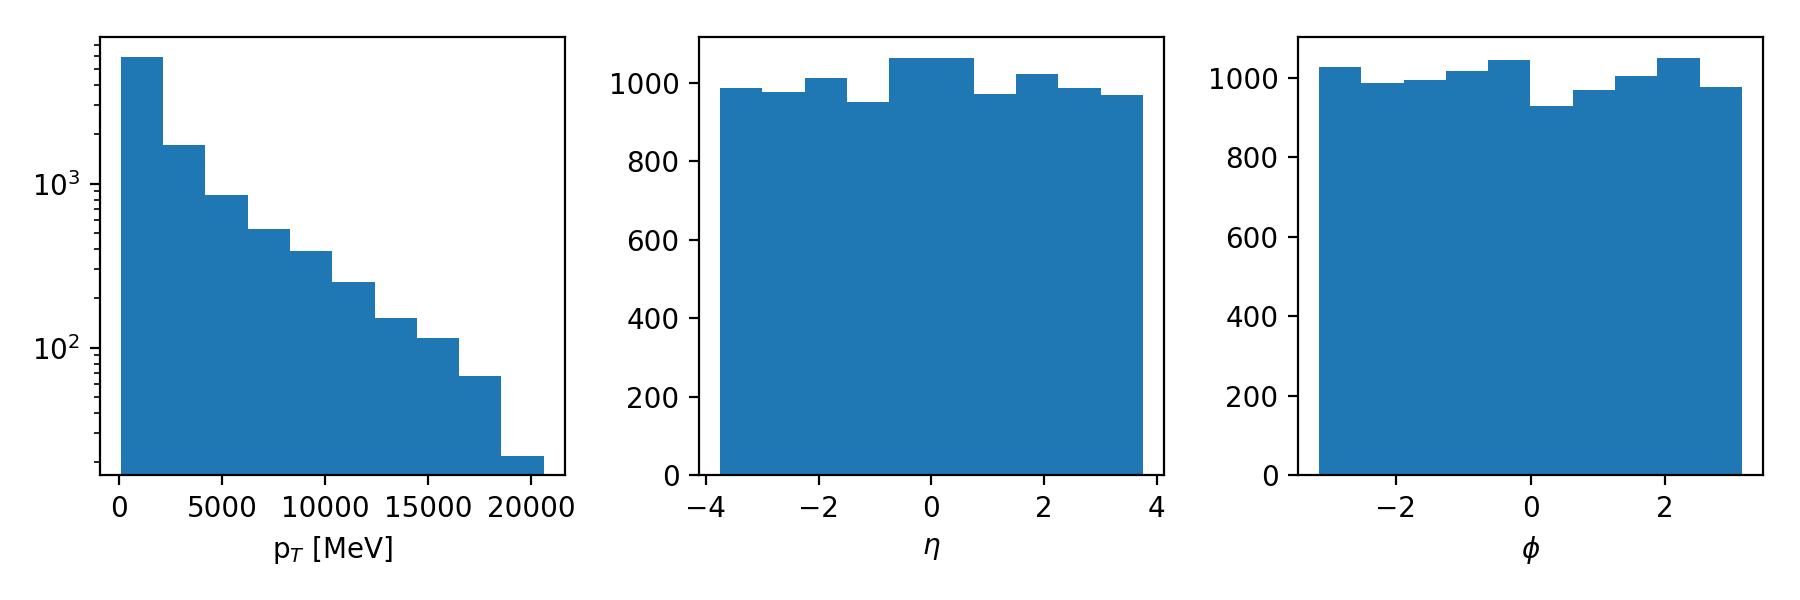

In [7]:
# Plot some track kinematics
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.hist(true_pt, log=True)
plt.xlabel('p$_T$ [MeV]')
plt.subplot(132)
plt.hist(true_eta)
plt.xlabel('$\eta$')
plt.subplot(133)
plt.hist(true_phi)
plt.xlabel('$\phi$')
plt.tight_layout()

#### Hits plots

In [8]:
# Create flattened arrays for some simple tests
flat_rho = np.concatenate(rho)
flat_z = np.concatenate(z)
flat_rphi = np.concatenate(rphi)

<IPython.core.display.Javascript object>


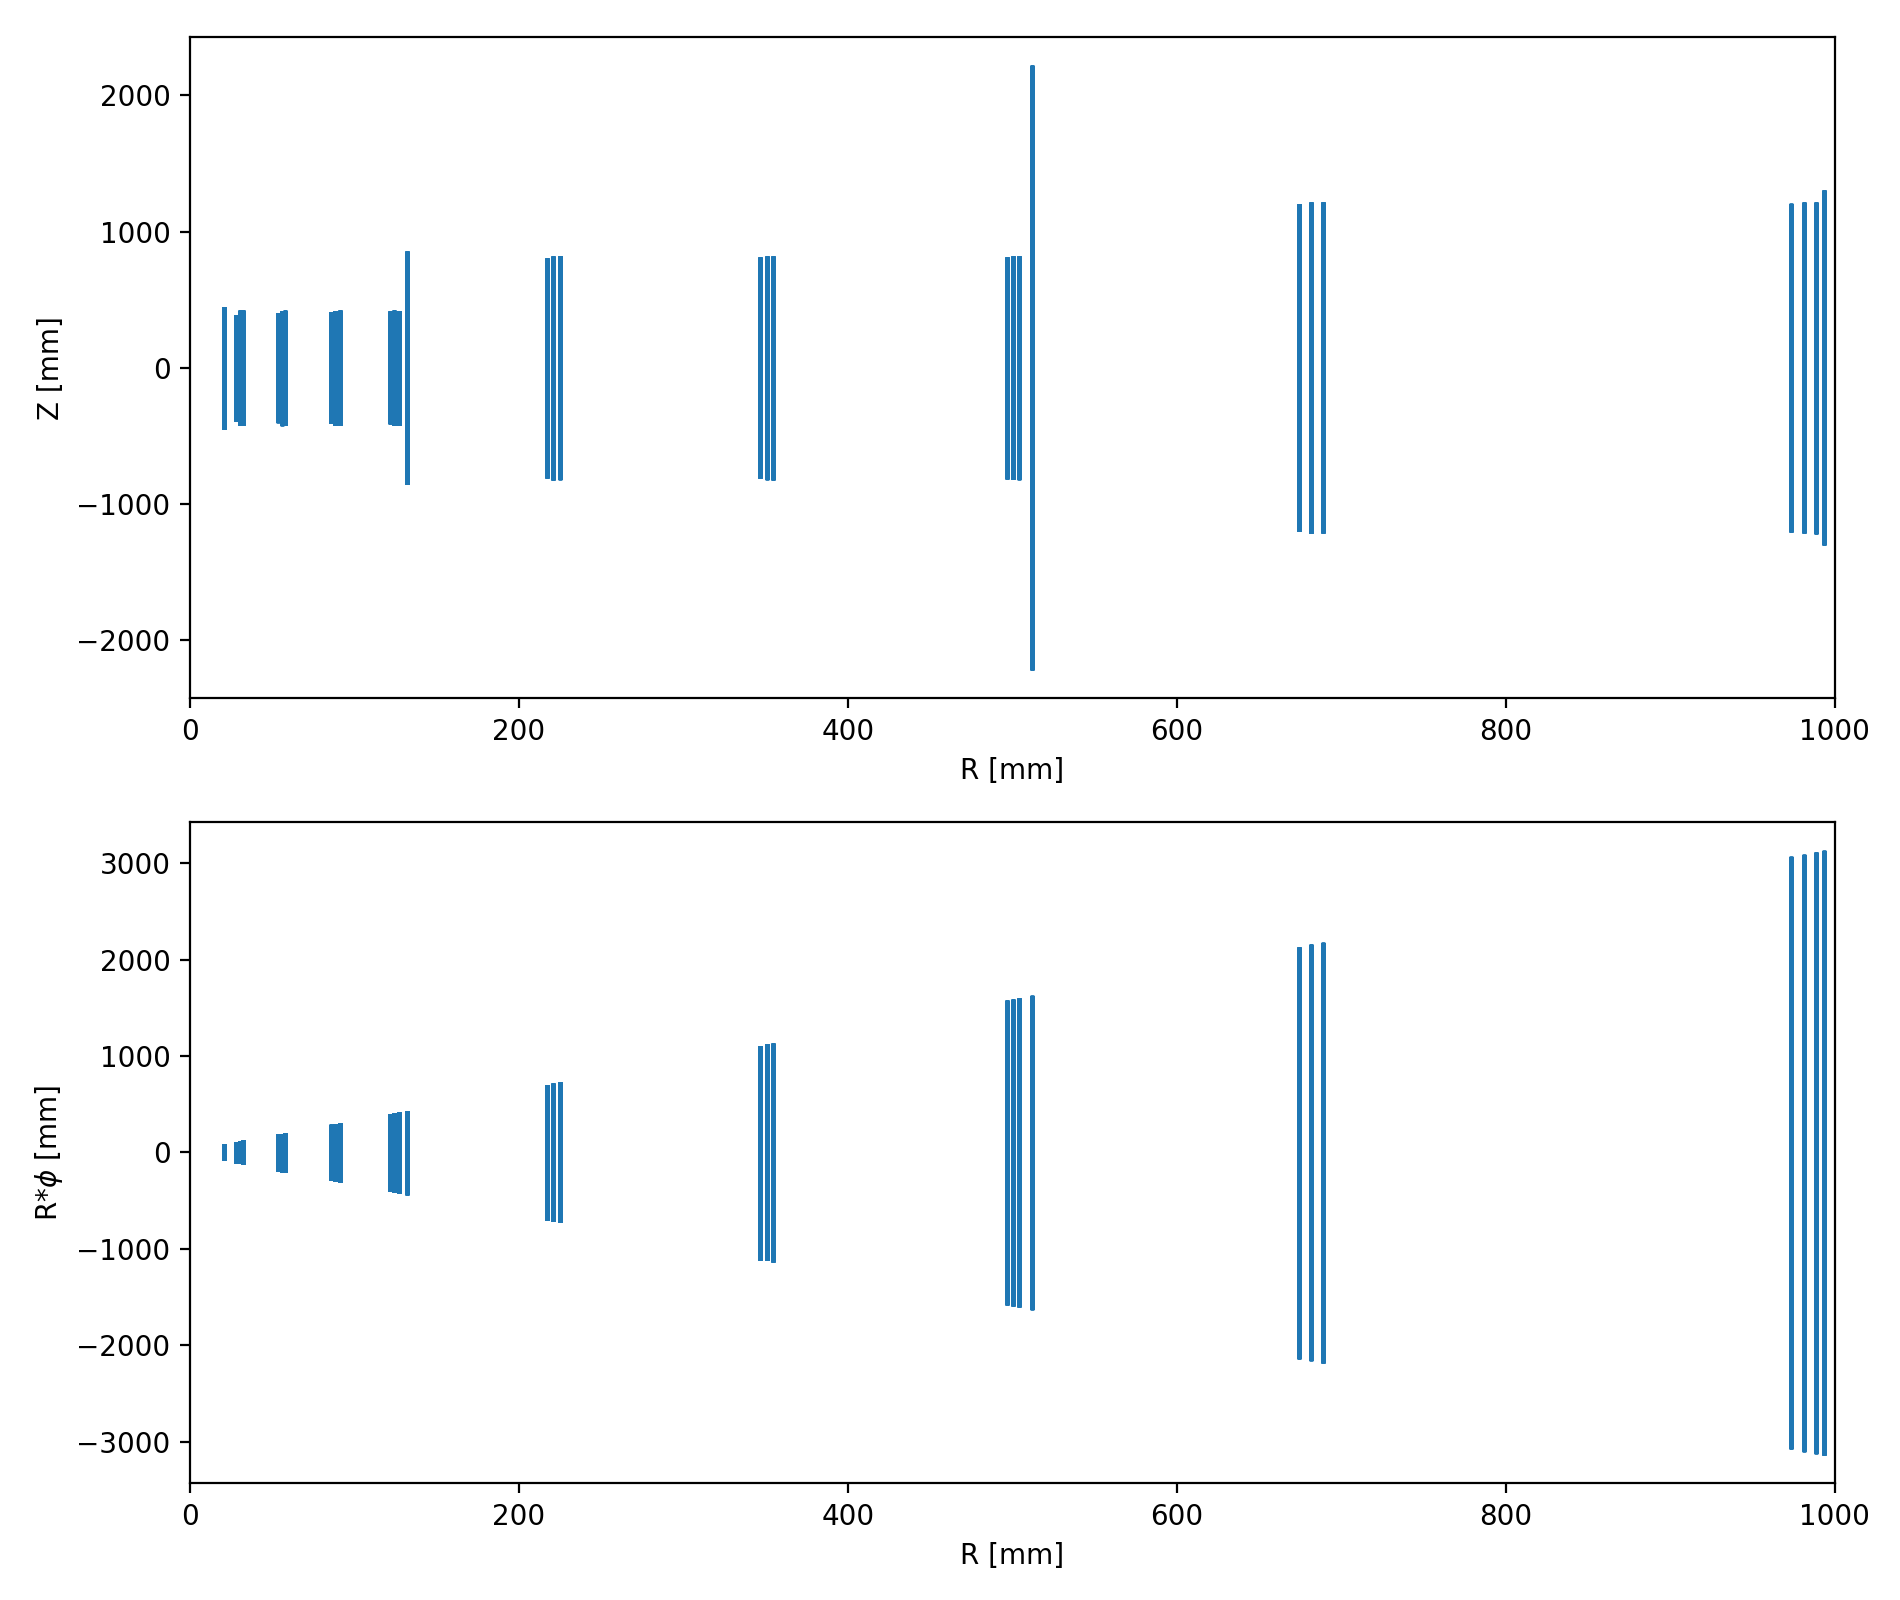

In [9]:
# Plot the distribution of hits
plt.figure(figsize=(9.5,8))
plt.subplot(211)
plt.scatter(flat_rho, flat_z, s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')
plt.xlim((0, 1000))

plt.subplot(212)
plt.scatter(flat_rho, flat_rphi, s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('R*$\phi$ [mm]')
plt.xlim((0, 1000))

plt.tight_layout()

<IPython.core.display.Javascript object>


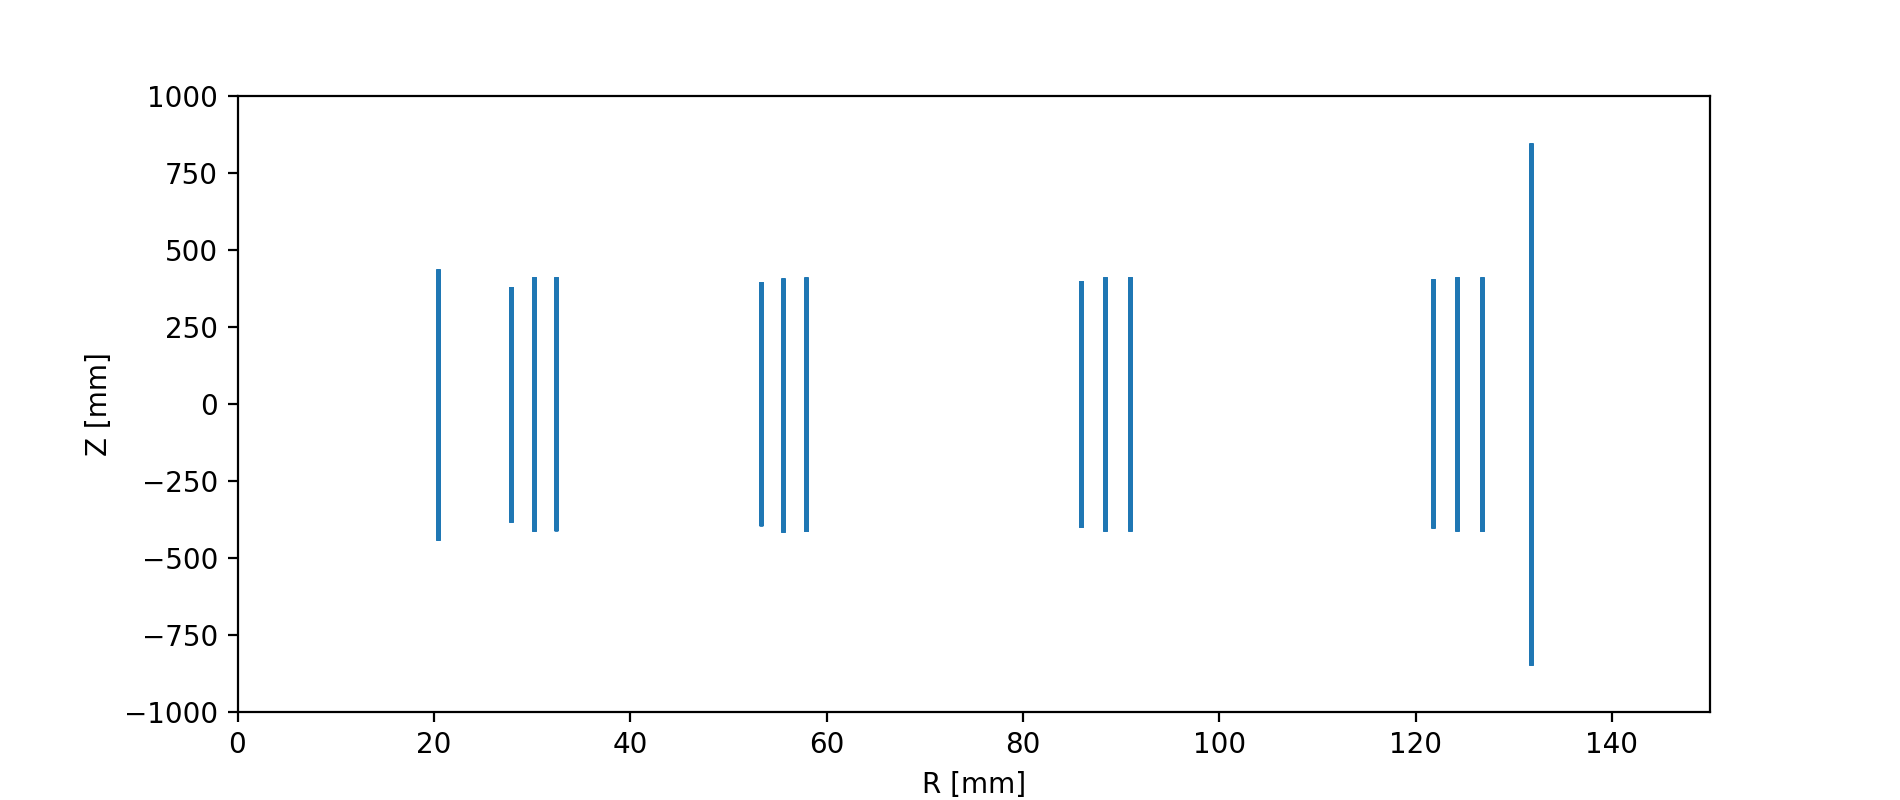

In [16]:
# Zoom in on the first four layers
plt.figure(figsize=(9.5,4))
plt.scatter(flat_rho, flat_z, s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')
plt.xlim((0, 150))
plt.ylim((-1000, 1000));

- There are apparently some auxilliary layer steps in this data. They may be detector volume envelopes.
- It looks like there are tracks escaping the barrel. These will have fewer numbers of steps.
- Each real layer produces three hit steps. We will have to collapse them somehow.

<IPython.core.display.Javascript object>


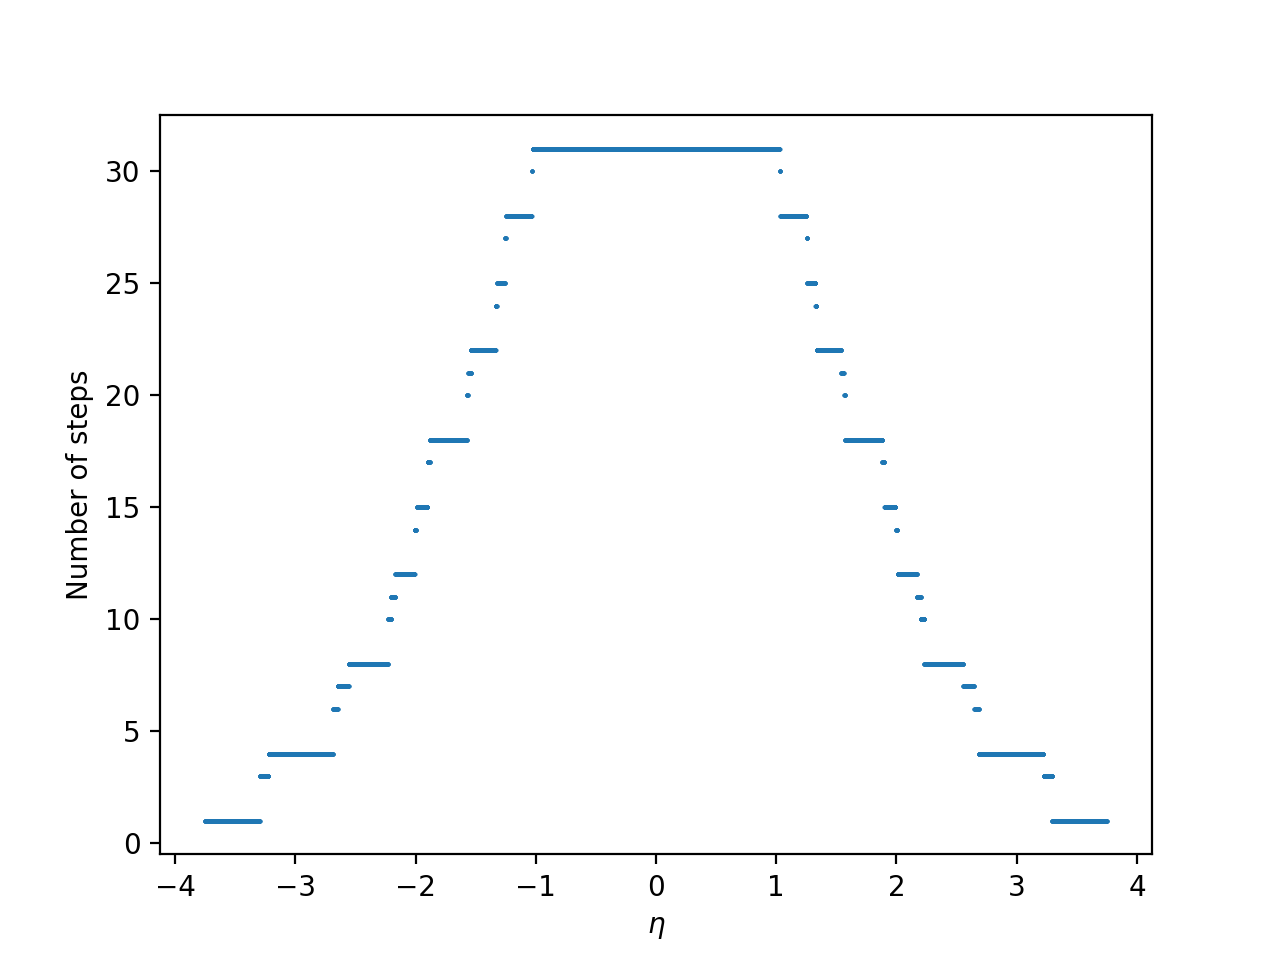

In [17]:
# See how number of steps varies with eta
plt.figure()
plt.scatter(true_eta, nstep, s=1, marker='.')
plt.xlabel('$\eta$')
plt.ylabel('Number of steps');

To select tracks that are in the barrel, we can cut on |eta| < 1. These tracks all have a fixed number of steps: 31.

In [18]:
# Ok, let's filter out all tracks not perfectly in the barrel.
true_theta, true_eta, true_phi, true_qop, true_pt = filter_samples(
    barrel_tracks, true_theta, true_eta, true_phi, true_qop, true_pt)
nstep, rphi, z, rho, phi = filter_samples(barrel_tracks, nstep, rphi, z, rho, phi)

# Recreate the flattened arrays
flat_rho = np.concatenate(rho)
flat_z = np.concatenate(z)
flat_rphi = np.concatenate(rphi)

<IPython.core.display.Javascript object>


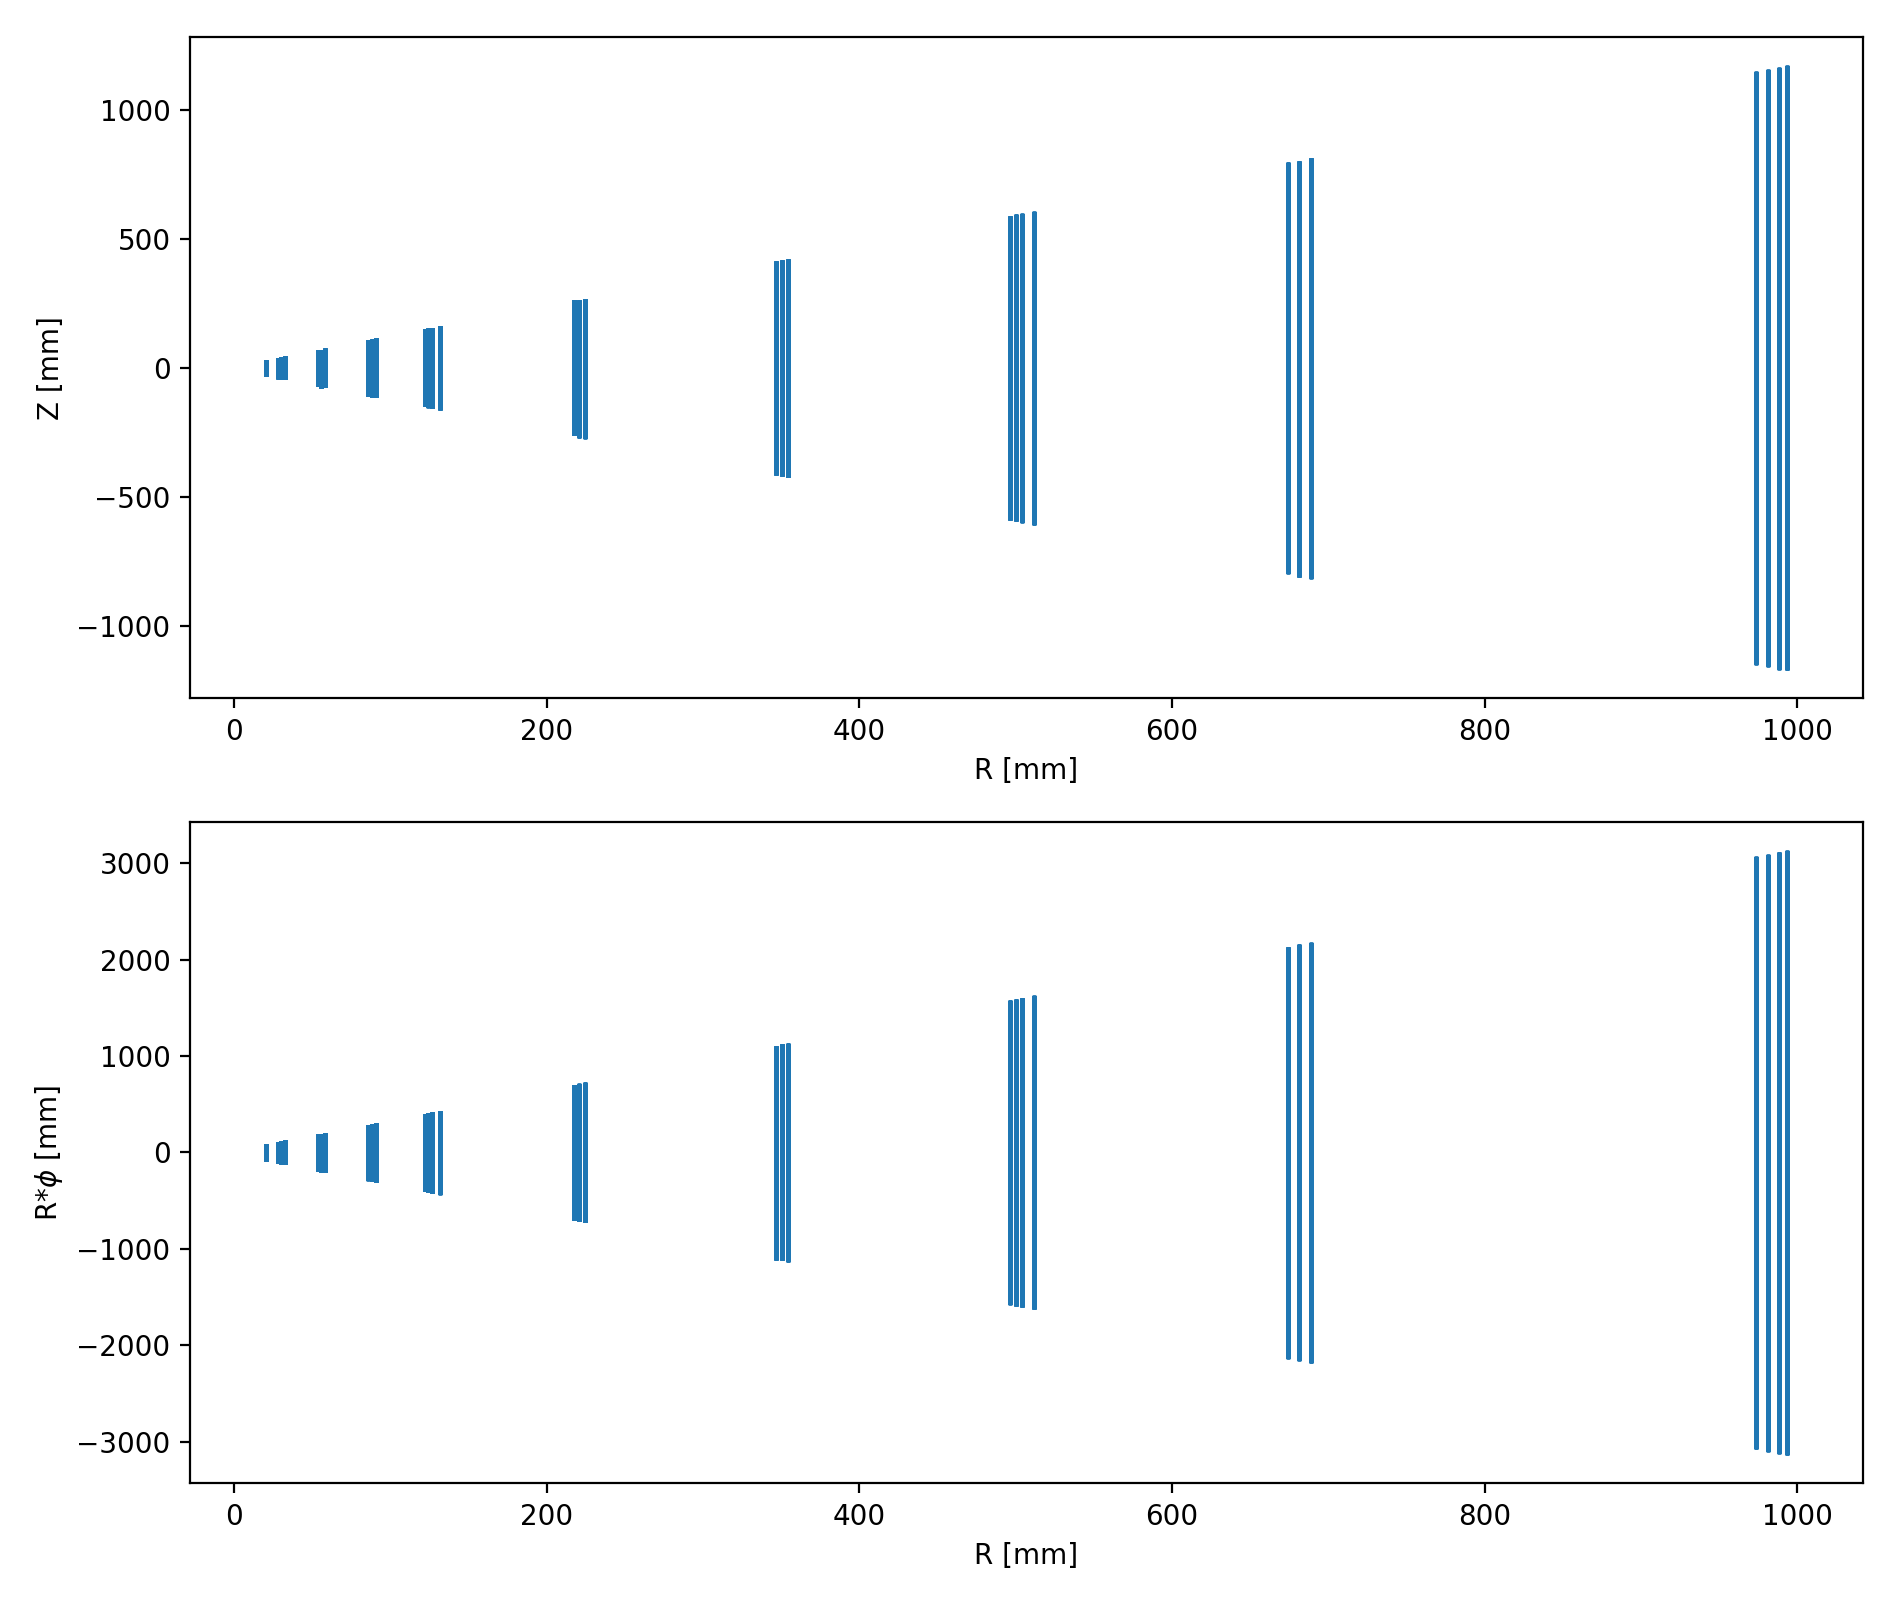

In [19]:
# Plot the distribution of hits
plt.figure(figsize=(9.5,8))
plt.subplot(211)
plt.scatter(flat_rho, flat_z, s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')

plt.subplot(212)
plt.scatter(flat_rho, flat_rphi, s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('R*$\phi$ [mm]')

plt.tight_layout()

By manual inspection, we found the ranges of rho which contain the actual detector layer hits we want.
We will take each layer triplet and average the coordinates to get a final spacepoint.

In [20]:
# Found by inspection
bin_edges = [25, 35, 50, 60, 85, 95, 120, 130, 210, 230, 300, 400, 490, 510, 650, 700, 970, 990]
layer_ranges = np.array(bin_edges).reshape((9, 2))

In [21]:
clp_rho, clp_rphi, clp_z = [], [], []
for (trk_rho, trk_rphi, trk_z) in zip(rho, rphi, z):
    clp_trk_rho, clp_trk_rphi, clp_trk_z = [], [], []
    for lay_range in layer_ranges:
        # Find the hits in this rho window
        idx = (trk_rho > lay_range[0]) & (trk_rho < lay_range[1])
        if idx.any():
            # Average the hits in this rho-window together
            clp_trk_rho.append(trk_rho[idx].mean())
            clp_trk_rphi.append(trk_rphi[idx].mean())
            clp_trk_z.append(trk_z[idx].mean())
    # Save this corrected track
    clp_rho.append(np.array(clp_trk_rho))
    clp_rphi.append(np.array(clp_trk_rphi))
    clp_z.append(np.array(clp_trk_z))

# Convert lists to np arrays
clp_rho, clp_rphi, clp_z = map(np.array, [clp_rho, clp_rphi, clp_z])
clp_phi = calc_phi(clp_rphi, clp_rho)

<IPython.core.display.Javascript object>


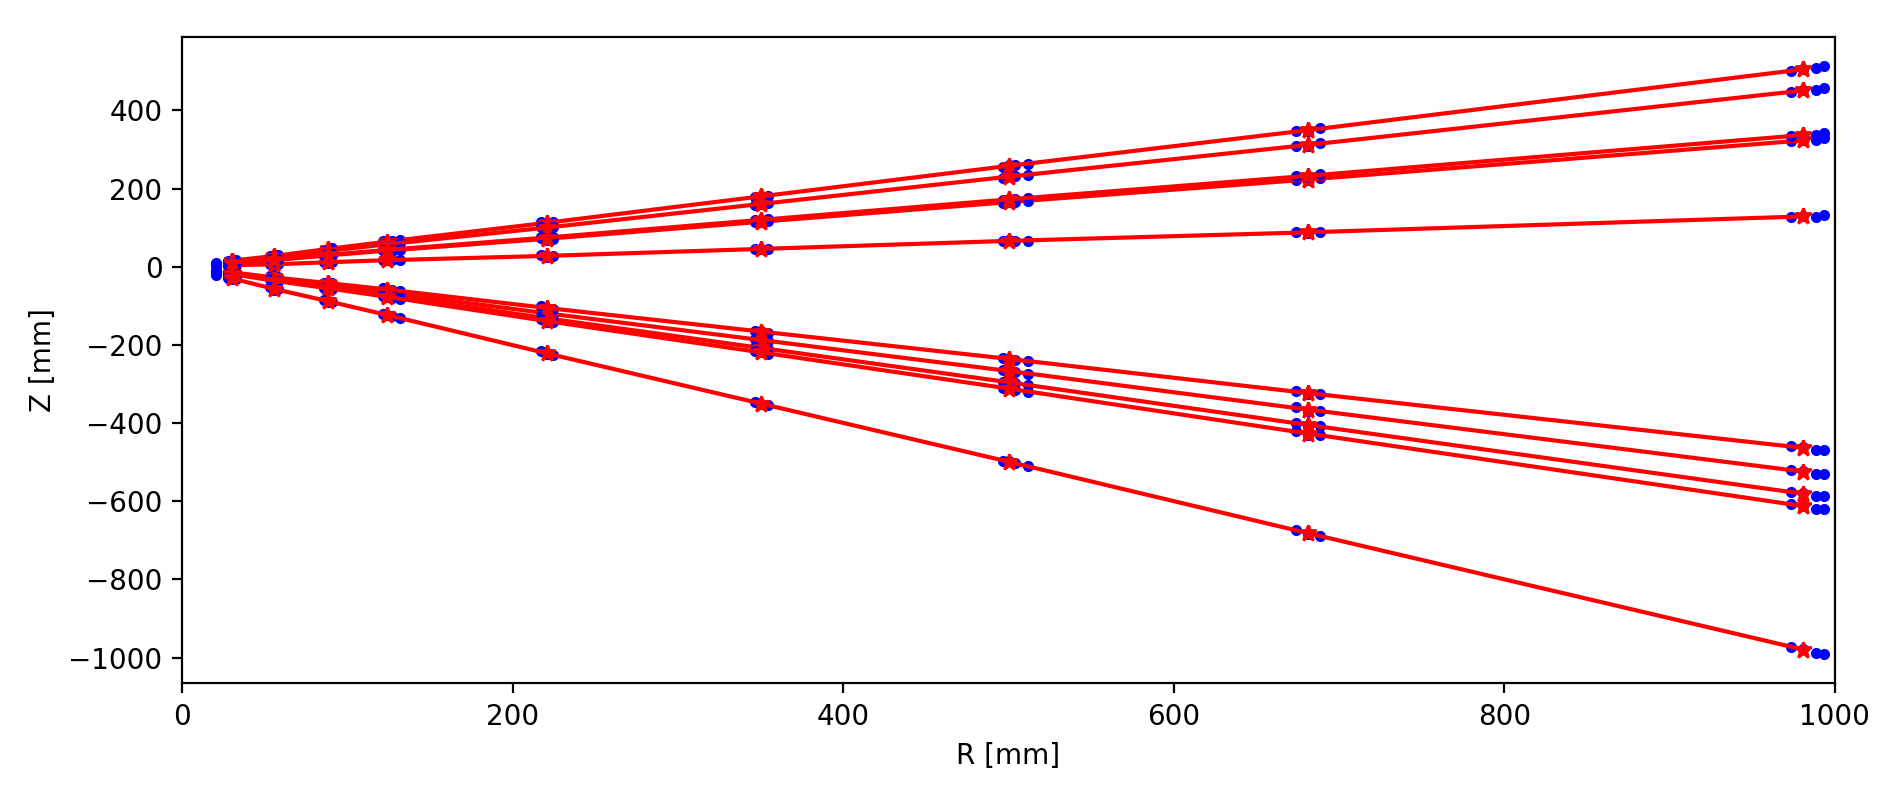

In [22]:
# Plot the original steps and my averaged hits for several tracks
plt.figure(figsize=(9.5,4))
for i in range(10):
    plt.plot(rho[i], z[i], 'b.')
    plt.plot(clp_rho[i], clp_z[i], 'r*-')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')
plt.xlim((0, 1000))
plt.tight_layout()

<IPython.core.display.Javascript object>


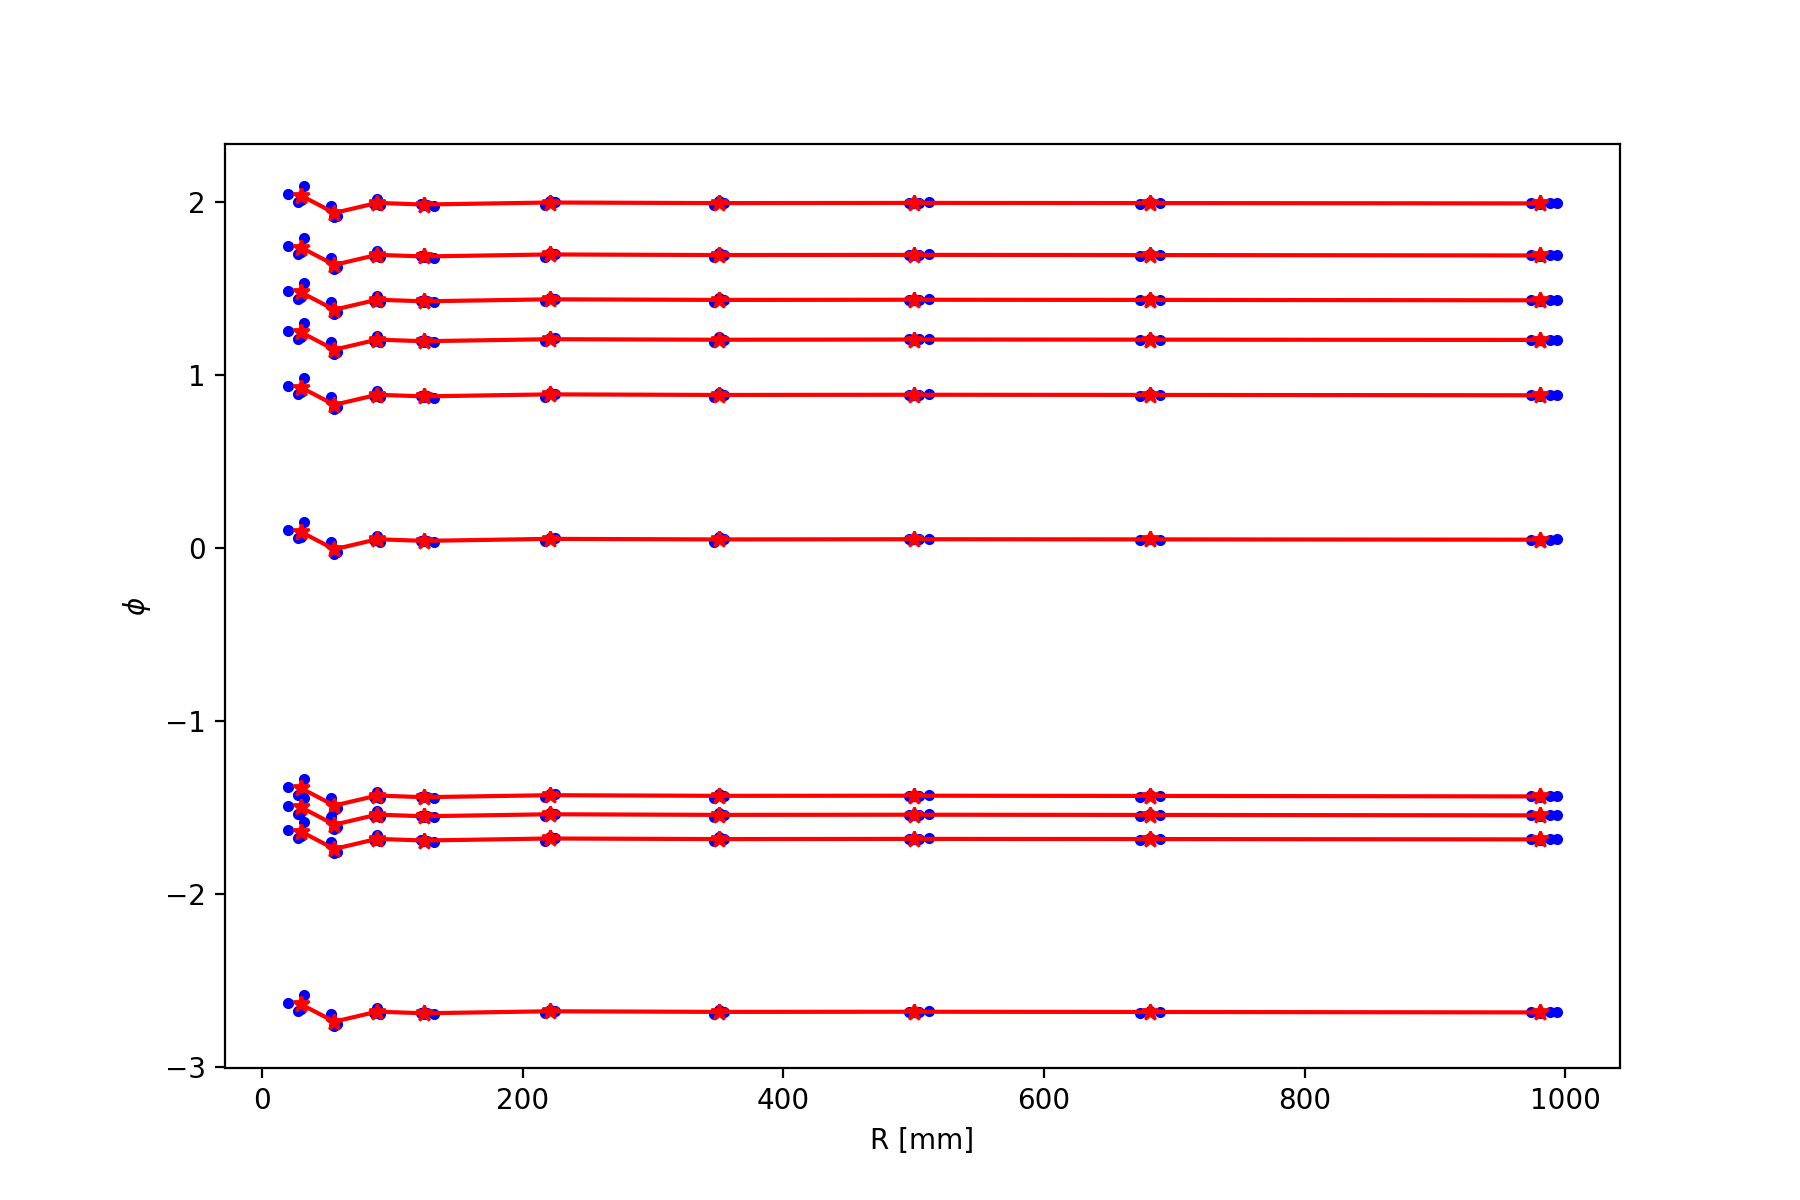

In [23]:
# Plot rho vs phi
plt.figure(figsize=(9,6))
for i in range(10):
    plt.plot(rho[i], phi[i], 'b.')
    plt.plot(clp_rho[i], clp_phi[i], 'r*-')
plt.xlabel('R [mm]')
plt.ylabel('$\phi$');

<IPython.core.display.Javascript object>


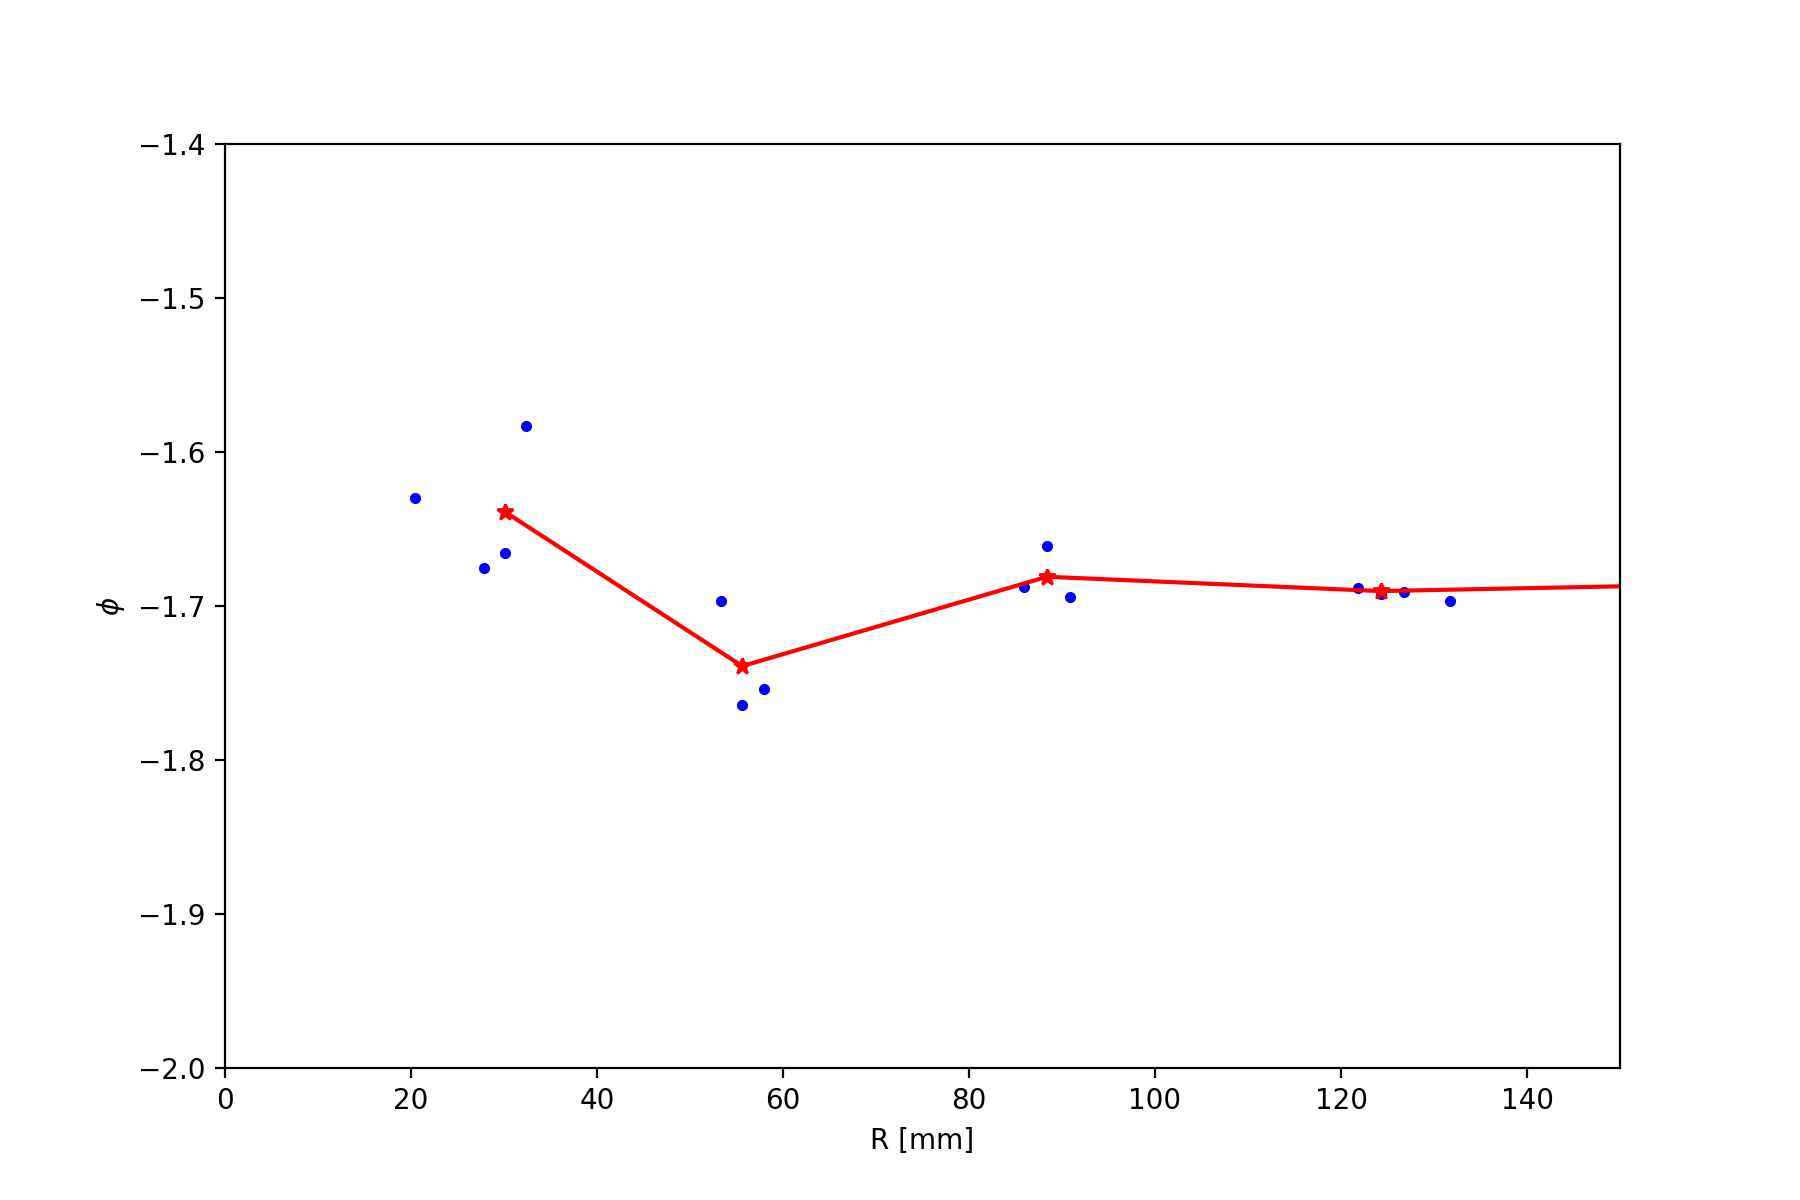

In [27]:
# Zoom in on the wiggle
plt.figure(figsize=(9,6))
for i in range(1):
    plt.plot(rho[i], phi[i], 'b.')
    plt.plot(clp_rho[i], clp_phi[i], 'r*-')
plt.xlabel('R [mm]')
plt.ylabel('$\phi$')
plt.xlim((0, 150))
plt.ylim((-2, -1.4));

There is seemingly something wrong with the phi calculation. There are systematic shifts in the first few hits. I suspect that the rho value used to calculate rphi is not the same rho that we have for the measurements.